## Illustrative Example

0.23454

0.13534

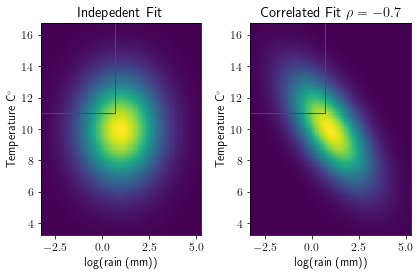

In [1]:
# Generate grid points

from scipy.stats import multivariate_normal
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12})
from matplotlib import patches
mu = np.array([1, 10])
cmat = np.array([[2,0],[0,5]])
cov = np.sqrt(cmat[0,0])*np.sqrt(cmat[1,1])*-0.7
cmat[0,1] = cov; cmat[1,0] = cov
mvn = multivariate_normal(mean = mu, cov = np.diag(np.diag(cmat)))
mvn_corr = multivariate_normal(mean = mu, cov=cmat)
add_x, add_y = (3*np.sqrt(cmat[i,i]) for i in range(2))
x, y = np.meshgrid(np.linspace(mu[0]-add_x,mu[0]+add_x, 100),np.linspace(mu[1]-add_y,mu[1]+add_y,100))
xy = np.column_stack([x.flat, y.flat])

# density values at the grid points
Z = mvn.pdf(xy).reshape(x.shape)
Z_corr = mvn_corr.pdf(xy).reshape(x.shape)

# arbitrary contour levels
contour_level = [0.01, 0.02, 0.05]
fig, ax = plt.subplots(1,2)
ax_labels = ["log(rain (mm))", "Temperature C$^\\circ$"]
ctf = ax[0].pcolormesh(x, y, Z, shading='auto')#levels = contour_level,color='b')
ax[0].set_title("Indepedent Fit")
ct2 = ax[1].pcolormesh(x, y, Z_corr, shading='nearest')
ax[1].set_title("Correlated Fit $\\rho=-0.7$")
for i in range(2):
    ax[i].set_xlabel(ax_labels[0]); ax[i].set_ylabel(ax_labels[1])
rect = patches.Rectangle((2, 12), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()

for i in range(2):
    rect = patches.Rectangle((np.log(2), 11), -40, 30, linewidth=1, edgecolor='r', facecolor='none')
    ax[i].add_patch(rect)
    ax[i].set_xlim(xlim); ax[i].set_ylim(ylim)
fig.tight_layout()
def estimate_prob_rect(dist, x_bounds = [-np.inf, np.log(2)], y_bounds = [11,np.inf], n_mc_samples=100000):
    mc_sims = dist.rvs(n_mc_samples)
    mask_x = np.logical_and(mc_sims[:,0]>x_bounds[0], mc_sims[:,0]<x_bounds[1]) 
    mask_y = np.logical_and(mc_sims[:,1]>y_bounds[0], mc_sims[:,1]<y_bounds[1])
    return np.sum(np.logical_and(mask_x, mask_y))/n_mc_samples
display(estimate_prob_rect(mvn_corr))
display(estimate_prob_rect(mvn))

fig.savefig("../Images/IllustrativeExample.pdf")

In [2]:
np.linalg.det(cmat)

6.0

In [157]:
np.linalg.det(np.diag(np.diag(cmat)))

9.999999999999998

In [145]:
import pandas as pd

In [17]:
data_folder= "../data/PRSA_Data_20130301-20170228/"

In [56]:
bejing = pd.read_csv("../data/PRSA_Data_20130301-20170228/PRSA_Data_Wanliu_20130301-20170228.csv")
rain_set = bejing[bejing['RAIN']>0]

,0,1
0,1.000000,0.143335
1,0.143335,1.000000


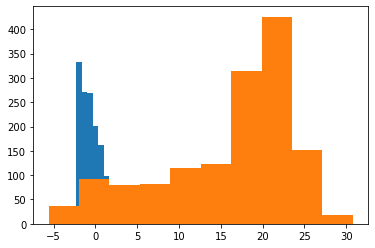

In [57]:
plt.hist(np.log(rain_set['RAIN']))
plt.hist(rain_set['TEMP'])
dset = np.vstack([np.log(rain_set['RAIN']).values, rain_set['TEMP'].values]).T
np.var(dset,axis=1)
pd.DataFrame(dset).corr()

In [61]:
np.var(np.log(rain_set['RAIN']))

1.9347887945586604

In [73]:
np.var(rain_set['TEMP'])

62.11321904120179

In [81]:
import pandas as pd
api_key = "ad726be15f9c08b9eca3a78087dade67eb46e6a242c9b2c72a49345affdcc357"
import cryptocompare
import numpy as np
import matplotlib.pyplot as plt

In [82]:
help(cryptocompare.get_historical_price_day)

Help on function get_historical_price_day in module cryptocompare.cryptocompare:

get_historical_price_day(coin: str, currency: str = 'EUR', limit: int = 1440, exchange: str = 'CCCAGG', toTs: Union[datetime.datetime, datetime.date, int, float] = 1620730733.0790706) -> Union[Dict, NoneType]
    Get historical price (day).
    
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param limit: number of data points (max. 2000)
    :param exchange: exchange to use (default: 'CCCAGG')
    :param toTs: return data before this timestamp. (Unix epoch time or datetime object)
    :returns: dict of coin and currency price pairs



In [220]:
def read_currency(name='BTC'):
    data = pd.DataFrame(cryptocompare.get_historical_price_day(name, currency='USD'))
    data['timestamp'] = data['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    data['log_ret'] = np.log(data['close']/data['close'].shift(1))
    data=data.dropna()
    return data[['log_ret', 'close','timestamp']]

In [221]:
currency = ['BTC', 'ETH']
df_BTC = read_currency(currency[0])
df_ETH = read_currency(currency[1])


In [222]:
out = pd.merge(df_BTC, df_ETH, on='timestamp', suffixes=["_"+currency_name for currency_name in currency])

In [223]:
out['timestamp']

0      2017-06-02 01:00:00
1      2017-06-03 01:00:00
2      2017-06-04 01:00:00
3      2017-06-05 01:00:00
4      2017-06-06 01:00:00
               ...        
1435   2021-05-07 01:00:00
1436   2021-05-08 01:00:00
1437   2021-05-09 01:00:00
1438   2021-05-10 01:00:00
1439   2021-05-11 01:00:00
Name: timestamp, Length: 1440, dtype: datetime64[ns]

In [239]:
num_lags = 12
def get_XY(num_lags):
    colnames = ['log_ret_'+currency_name for currency_name in currency]
    Y_df = out.set_index("timestamp")[colnames]*100
    X_df =  pd.concat((Y_df.shift(k) for k in range(1, num_lags+1)),axis=1)
    Y_reduced =Y_df.iloc[num_lags:]
    ts = Y_reduced.index
    Y = Y_reduced.values
    X=X_df.iloc[num_lags:].values
    return X,Y, ts

In [240]:
out
np.log(2545.43/2492.6)
out

,log_ret_BTC,close_BTC,timestamp,log_ret_ETH,close_ETH
0,0.032601,2492.60,2017-06-02 01:00:00,0.006053,222.04
1,0.020973,2545.43,2017-06-03 01:00:00,0.007627,223.74
2,-0.008431,2524.06,2017-06-04 01:00:00,0.090610,244.96
3,0.069218,2704.96,2017-06-05 01:00:00,0.011325,247.75
4,0.059399,2870.50,2017-06-06 01:00:00,0.064513,264.26
...,...,...,...,...,...
1435,0.016384,57374.33,2021-05-07 01:00:00,-0.002231,3483.96
1436,0.026976,58943.13,2021-05-08 01:00:00,0.116965,3916.25
1437,-0.011071,58294.18,2021-05-09 01:00:00,0.002756,3927.06
1438,-0.042475,55870.01,2021-05-10 01:00:00,0.005766,3949.77


In [254]:
X,Y, ts = get_XY(7)
N = X.shape[0]
validation = int(N*0.9)
test = int(N*0.95)
Y_train = Y[:validation,:]
X_train = X[:validation,:]
X_valid = X[validation:test]
Y_valid = Y[validation:test,:]
X_test = X[test:]
Y_test = Y[test:]

In [255]:
from probdrift.mvn_models import mvn_ngboost, mvn_neuralnetwork

In [256]:
model = mvn_ngboost()#params={"params_ngboost":{"natural_gradient":True}})
model.fit(X_train, Y_train, X_valid, Y_valid)
pred_dist = model.scipy_distribution(X_test)
print(np.mean([dist.logpdf(y) for dist,y in zip(pred_dist,Y_test)]))

{'criterion': 'friedman_mse', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'max_leaf_nodes': 31, 'max_depth': 3, 'splitter': 'best'}
[iter 0] loss=5.5871 val_loss=6.1575 scale=0.1250 norm=0.6471
[iter 10] loss=5.5362 val_loss=6.1618 scale=0.2500 norm=1.2869
[iter 20] loss=5.4950 val_loss=6.1645 scale=0.2500 norm=1.2819
[iter 30] loss=5.4574 val_loss=6.1621 scale=0.5000 norm=2.5558
[iter 40] loss=5.4263 val_loss=6.1632 scale=0.5000 norm=2.5483
[iter 50] loss=5.3967 val_loss=6.1704 scale=0.5000 norm=2.5395
[iter 60] loss=5.3693 val_loss=6.1762 scale=1.0000 norm=5.0631
[iter 70] loss=5.3418 val_loss=6.1878 scale=0.5000 norm=2.5228
[iter 80] loss=5.3192 val_loss=6.1963 scale=0.5000 norm=2.5162
[iter 90] loss=5.2981 val_loss=6.2062 scale=0.5000 norm=2.5096
== Early stopping achieved.
== Best iteration / VAL0 (val_loss=6.1575)
-5.421377546282241


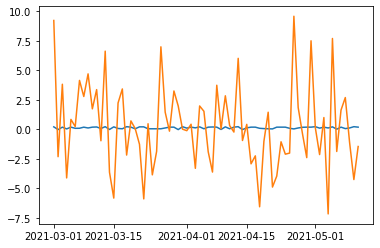

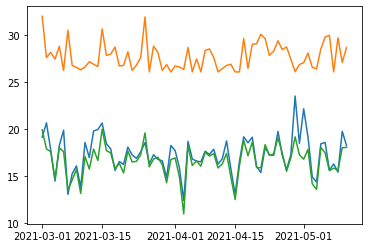

In [257]:
pred_dist = model.scipy_distribution(X_test)
def extract_sigma_rho(scipy_dist):
    cmat = scipy_dist.cov
    sigma = np.sqrt(np.diag(cmat))
    rho = cmat[0,1]/sigma[0]/sigma[1]
    return sigma, rho
sigma_rho = [extract_sigma_rho(dist) for dist in pred_dist]
plt.plot(ts[test:], [dist.mean[0] for dist in pred_dist])
plt.plot(ts[test:], Y_test[:,0])

fig = plt.figure()
plt.plot(ts[test:], [sigma[0]**2 for sigma, _ in sigma_rho], label = '$\\sigma_1$')
plt.plot(ts[test:], [sigma[1]**2 for sigma, _ in sigma_rho], label = '$\\sigma_2$')
plt.plot(ts[test:], [rho*sigma[0]*sigma[1] for sigma, rho in sigma_rho], label = '$\\rho$')


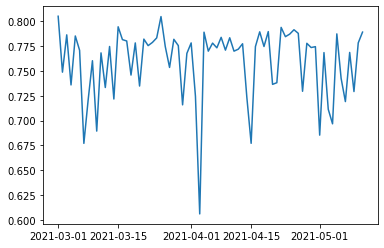

In [258]:
plt.plot(ts[test:] , [rho for  _, rho in sigma_rho])

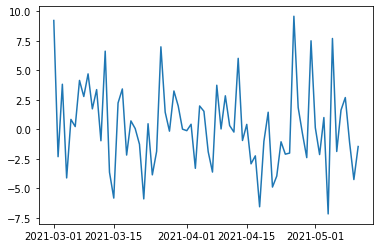

In [261]:
plt.plot(ts[test:], Y_test[:,0])

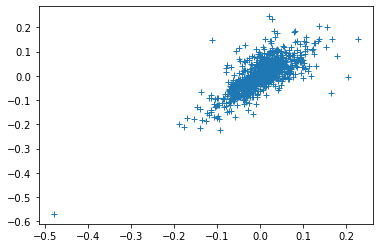

In [179]:
plt.plot(ts[:validation], [rho for sigma, rho in sigma_rho], label = '$\\rho$')

-4.90697441586062


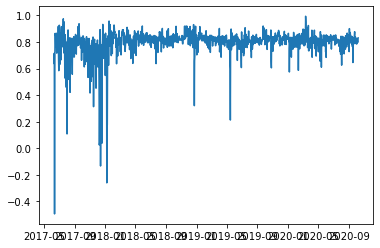

In [247]:
pred_dist = model.scipy_distribution(X_train)
sigma_rho = [extract_sigma_rho(dist) for dist in pred_dist]
print(np.mean([dist.logpdf(y) for dist,y in zip(pred_dist,Y_train)]))
plt.plot(ts[:validation], [rho for sigma, rho in sigma_rho], label = '$\\rho$')